## Blinded cameras clustering

Here the dataset is a pandas DataFrame generated from a response.drdf file. 
The file can be found at "/storage/gpfs_data/neutrino/SAND-LAr/SAND-LAr-GRAIN-CALORIMETRY/data/cube_production/production1/cube_X0_Y0_Z-3/output/response_cut.drdf".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import skimage
from joblib import Parallel, delayed

### Read data from pickle format

Compose data array from dataframe column, keeping different cameras in the rows, while columns represent the pixels

In [2]:
#module_path = os.path.abspath(os.path.join('..'))
df = pd.read_pickle("blind_cameras_dataset\\drdf_arrays.pkl")

df2arr = df.pixels.to_numpy()
arr3d = np.stack(df2arr)
data = arr3d.reshape(df2arr.shape[0],32*32)


In [3]:
# NB this os the proof of how the reshape method works!!
# t0 = test[0]
# t1 = test1[0]
# d = np.empty(0)
# for i in range(32):
#     for j in range(32):
#         diff = t0[i,j] - t1[i*32+j]
#         d = np.apltend(d,diff)
        
# print(np.min(d), np.max(d))

### Show distribution of data from the entire file

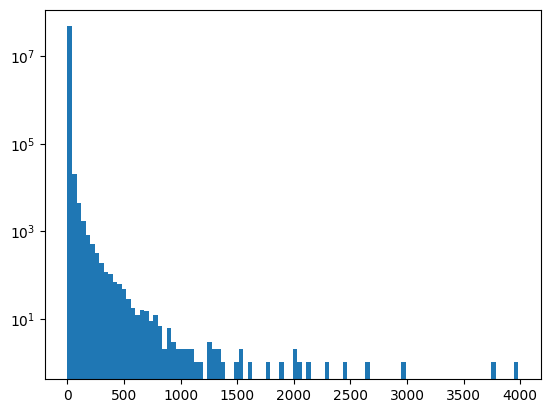

In [4]:
plt.hist(data.reshape(-1,1),100)
plt.yscale('log')

### Filter data

In [5]:
def task(camera):
    thr = skimage.filters.threshold_minimum(image=camera, nbins=1024, max_num_iter=1000000)
    return thr

filter = False

if filter:
    thresholds = Parallel(n_jobs=5)(delayed(task)(i) for i in arr3d[:2000])
    
    print(thresholds)
    thr = np.array(thresholds).reshape(-1,1)
    filt = (data[:1000] > thr)*thr
    filt.shape

N.B. takes 14 min

In [6]:
if not filter:
    hess = skimage.filters.hessian(arr3d)
    hess.shape
    filt = (hess*arr3d).reshape(-1,1024)

### Find probable blinded cameras through simple amplitude considerations

In [43]:
index = np.empty(0)

for img in arr3d:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index = np.append(index, 1)
        else :
            index = np.append(index, 0) 
    else :
        index = np.append(index, 0) 
        
print(index[index == 1].size, 'over', arr3d.shape[0])
assigned_blind = arr3d[np.where(index == 1)]
#print(np.where(index == 1))

491 over 46968


### Use the KMean algorithm to clusterise the datasample.
The same data are the processed to check the clusterization.

In [72]:
# Declaring Model
# model = KMeans(n_clusters=3)
# model1 = KMeans(init="random", n_clusters=3, n_init=20, random_state=0)
# model2 = KMeans(init="k-means++", n_clusters=3, n_init=20, random_state=0)
model3 = KMeans(init="k-means++", n_clusters=7, n_init=20, random_state=0)
# Fitting Model
# model.fit(data)
# model1.fit(data)
# model2.fit(data)
model3.fit(filt)

# print(np.count_nonzero(model1.labels_ == 0), np.count_nonzero(model1.labels_ == 1), np.count_nonzero(model1.labels_ == 2))
# print(np.count_nonzero(model2.labels_ == 0), np.count_nonzero(model2.labels_ == 1), np.count_nonzero(model2.labels_ == 2))
print(np.count_nonzero(model3.labels_ == 0), np.count_nonzero(model3.labels_ == 1), np.count_nonzero(model3.labels_ == 2), np.count_nonzero(model3.labels_ == 3), np.count_nonzero(model3.labels_ == 4))

lb3 = model3.predict(filt)

45684 131 13 1 2


#### Model evaluation

In [73]:
clustered_blind_idx = np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4) | (lb3 == 5)| (lb3 == 6))[0]

common_cameras = np.intersect1d(clustered_blind_idx, np.where(index == 1))
print('true positive =', common_cameras.shape[0], '/', assigned_blind.shape[0], '=', common_cameras.shape[0]/assigned_blind.shape[0]*100, '%')
print('false positive =', clustered_blind_idx.shape[0] - common_cameras.shape[0], '/', clustered_blind_idx.shape[0], '=', (clustered_blind_idx.shape[0] - common_cameras.shape[0])/clustered_blind_idx.shape[0]*100, '%')

true positive = 391 / 491 = 79.63340122199592 %
false positive = 893 / 1284 = 69.54828660436138 %


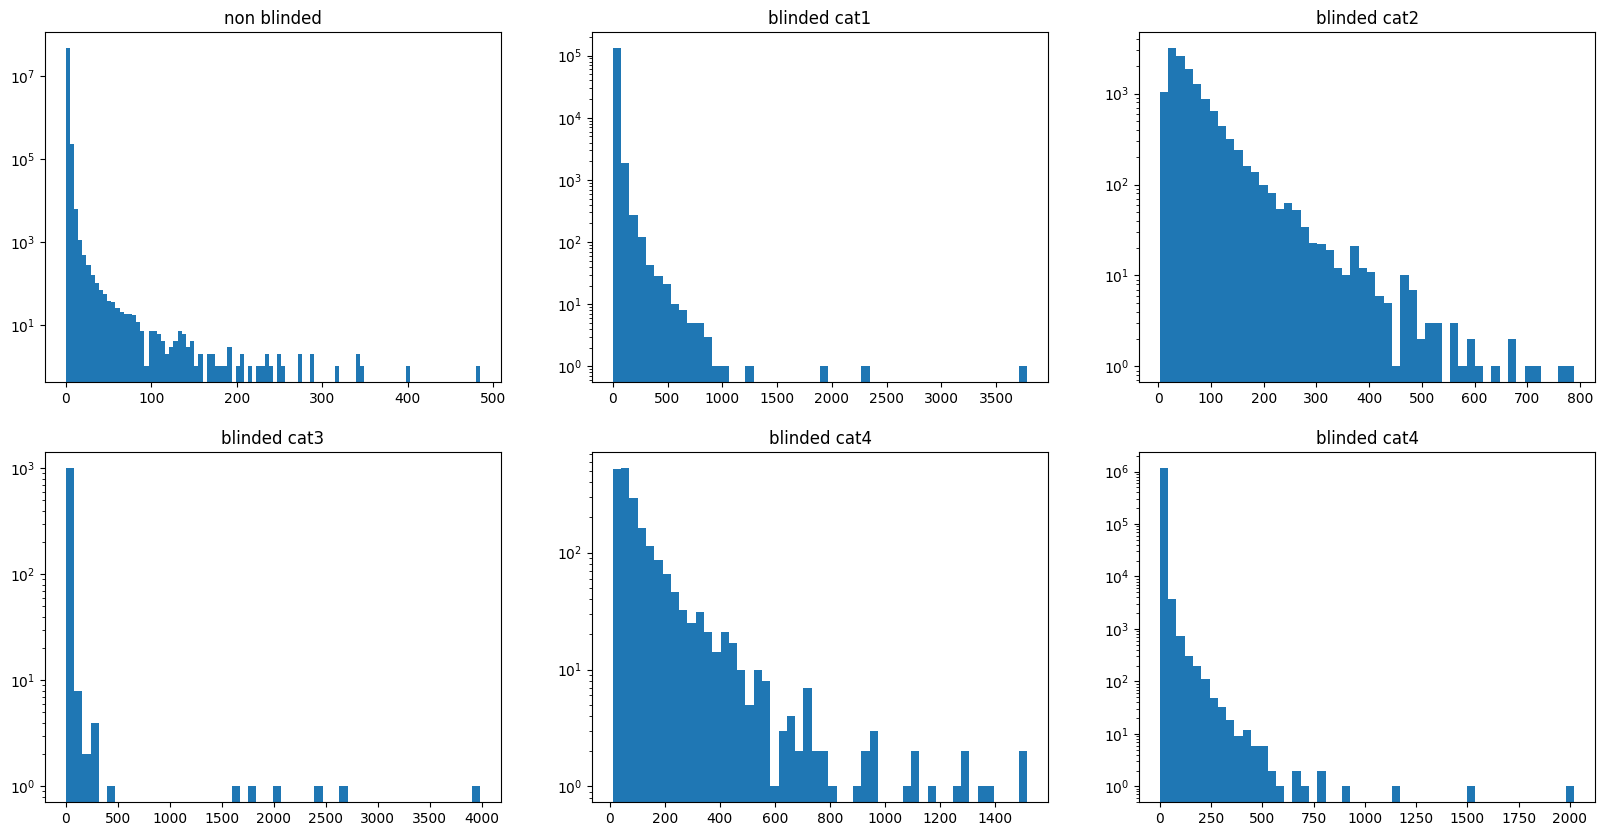

In [69]:

#bl3 = np.where(lb3 == 2)
#bl3 = np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4))
#   blind_in_common3 = np.intersect1d(blind_candidate, blind_candidate[bl3[0]])
#blind_in_common3 = np.intersect1d(blind_candidate, bl3[0])
#   print('common blind =', blind_in_common3.size,'out of',bl3[0].size, 'predicted.\nCandidates were',blind_candidate.size)
#   blind_not_in_common3 = np.setdiff1d(blind_candidate[bl3[0]], blind_in_common3, assume_unique=True)
#blind_not_in_common3 = np.setdiff1d(bl3[0], blind_in_common3, assume_unique=True) #returns the value in arr1 which are not in arr2
#   print('not in common :',blind_not_in_common3)

# plot photon hit distribution of cluster 0,1,2 separately
fig, ax = plt.subplots(2,3)

#ax[0].hist(data[np.where(lb3 == 0)[0]].reshape(-1,1),100)
ax[0,0].hist(data[np.where(lb3 == 0)[0]].reshape(-1,1),100)
ax [0,0].set_yscale('log')
ax[0,0].set_title('non blinded')

#ax[1].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax[0,1].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [0,1].set_yscale('log')
ax[0,1].set_title('blinded cat1')

ax[0,2].hist(data[np.where(lb3 == 2)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [0,2].set_yscale('log')
ax[0,2].set_title('blinded cat2')

ax[1,0].hist(data[np.where(lb3 == 3)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,0].set_yscale('log')
ax[1,0].set_title('blinded cat3')

ax[1,1].hist(data[np.where(lb3 == 4)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,1].set_yscale('log')
ax[1,1].set_title('blinded cat4')

ax[1,2].hist(data[np.where(lb3 == 6)[0]].reshape(-1,1),50)
#ax[2].hist(data[np.where(lb3 == 1)[0]].reshape(-1,1),50)
ax [1,2].set_yscale('log')
ax[1,2].set_title('blinded cat4')

fig.set_figwidth(20)
fig.set_figheight(10)

In [9]:
#np.where(lb3 == 4)[0]

array([   17,    63,    64,    69,   245,   397,   473,   671,   701,
         929,   970,   975,  1005,  1127,  1157,  1203,  1233,  1274,
        1385,  1461,  1507,  1537,  1603,  1689,  1841,  2069,  2373,
        2494,  2525,  2723,  2799,  2804,  2829,  2874,  3133,  3284,
        3285,  3325,  3402,  3665,  3969,  4015,  4273,  4395,  4623,
        4729,  4957,  5154,  5261,  5308,  5413,  5458,  5463,  5464,
        5489,  5717,  5793,  5869,  6173,  6249,  6446,  6477,  6533,
        6553,  7085,  7131,  7160,  7161,  7283,  7360,  7510,  7541,
        8068,  8073,  8077,  8301,  8347,  8377,  8528,  8574,  8576,
        8605,  8651,  8682,  8909,  9107,  9223,  9593,  9745,  9821,
        9897,  9943,  9973, 10125, 10201, 10247, 10581, 10961, 11037,
       11265, 11553, 11569, 11616, 11797, 12177, 12299, 12405, 12481,
       12633, 12785, 13165, 13241, 13242, 13287, 13317, 13363, 13364,
       13506, 13621, 13673, 13696, 13697, 13925, 13969, 14001, 14002,
       14077, 14153,

In [44]:
blind = data[np.where((lb3 == 1) | (lb3 == 2) | (lb3 == 3) | (lb3 == 4) | (lb3 == 5))]
not_blind = data[np.where(lb3 == 0)]

index_b = np.empty(0)
index_nb = np.empty(0)

for img in blind:
    if np.max(img)/np.mean(img) > 7:
        index_b = np.append(index_b, 1)
    else :
        index_b = np.append(index_b, 0)

print(index_b[index_b == 1].size, 'over', blind.shape[0])
filtered_blind = blind[np.where(index_b == 1)]
#print(np.where(index_b == 1))

for img in not_blind:
    if (np.amax(img) > 40):
        if (np.amax(img)/np.mean(img) > 7):
            index_nb = np.append(index_nb, 1)
        else :
            index_nb = np.append(index_nb, 0) 
    else :
        index_nb = np.append(index_nb, 0) 
        
print(index_nb[index_nb == 1].size, 'over', not_blind.shape[0])
filtered_not_blind = not_blind[np.where(index_nb == 1)]
#print(np.where(index_nb == 1))

209 over 501
282 over 46467
(array([   57,   588,   894,   960,   963,  1119,  1266,  1496,  2467,
        3298,  3746,  3822,  3971,  4043,  4124,  4248,  4346,  4508,
        4952,  4955,  5106,  5181,  5409,  5410,  5706,  5855,  6008,
        6234,  6385,  6534,  6546,  6610,  6684,  6841,  6913,  7437,
        7769,  7829,  7895,  7971,  8200,  8420,  8495,  8569,  8716,
        8858,  9017,  9169,  9333,  9540,  9608,  9732, 10003, 10056,
       10067, 10069, 10365, 10368, 10530, 10753, 10784, 10824, 10950,
       11131, 11282, 11363, 11429, 11443, 11512, 11918, 12173, 12191,
       12217, 12563, 12867, 13171, 13305, 13467, 13609, 13850, 13920,
       14219, 14362, 14514, 14680, 14695, 14726, 14737, 14893, 15033,
       15129, 15169, 15332, 15408, 15479, 15508, 15559, 16389, 16776,
       16913, 17061, 17513, 17695, 17740, 17741, 17742, 18029, 18137,
       18141, 18416, 18716, 18936, 19025, 19093, 19169, 19249, 19316,
       19392, 19462, 19762, 19842, 20065, 20444, 20523, 20771

### Plot photon distribution for 1 camera

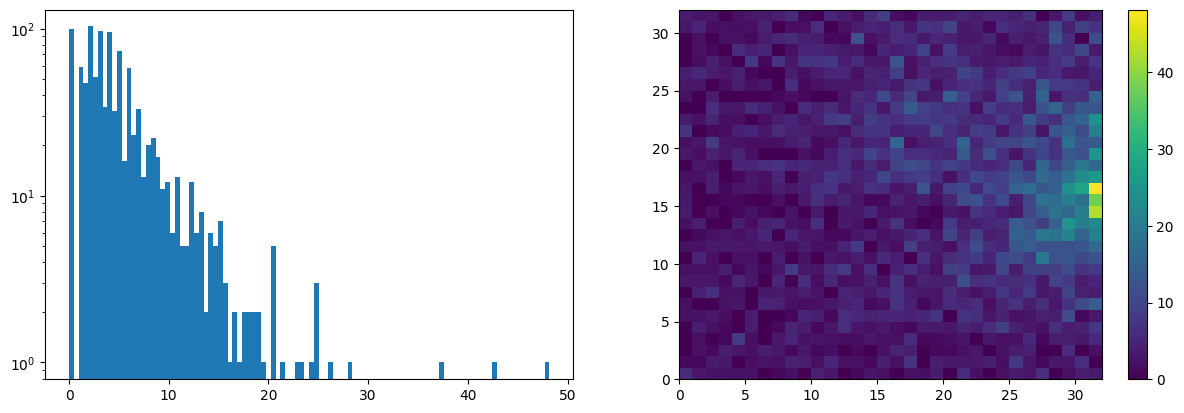

In [41]:
data_num = 15479

fig, ax = plt.subplots(1,2)
ax[0].hist(not_blind[data_num],100)
ax[0].set_yscale('log')

#camera = np.reshape(df.iloc[162].pixels, (32,32))
cam = ax[1].pcolormesh(not_blind[data_num].reshape(32,32))
#cam = ax[1].pcolormesh(arr3d[data_num])
plt.colorbar(cam)

fig.set_figwidth(15)

### save cameras to pdf

In [12]:
write_pdf = True
if (filtered_blind.shape[0] < 1000) & (write_pdf) :
    pdf = PdfPages('blinded_filtered.pdf')
    for num in filtered_blind:
        fig = plt.figure()
        cam = plt.pcolormesh(num.reshape(32,32))
        plt.colorbar(cam)
        #plt.title('cam-'+str(num))
        pdf.savefig(fig)
        plt.close()
    pdf.close()
    
if (blind.shape[0] < 1000) & (write_pdf) :
    pdf = PdfPages('blinded.pdf')
    for num in blind:
        fig = plt.figure()
        cam = plt.pcolormesh(num.reshape(32,32))
        plt.colorbar(cam)
        #plt.title('cam-'+str(num))
        pdf.savefig(fig)
        plt.close()
    pdf.close()

#### Save to pickle file

In [13]:
save = True
if save:
    np.save('blind_cameras_dataset/blinded_filtered.npy',filtered_blind)
    np.save('blind_cameras_dataset/blinded.npy',blind)

#### Read from pickle file

In [14]:
read = False
if read:
    with open('blind_cameras_dataset/blinded.npy', 'rb') as f:
        load_blind = np.load(f)